# Summarise beta coefficients


In [1]:
import os
import sys
import warnings
import distinctipy
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sb
from scipy import stats
import contextily as ctx
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
import matplotlib.colors as colors
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _prediction import allNaN_arg

%matplotlib inline

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


## Open data


In [2]:
base='/g/data/os22/chad_tmp/Aus_CO2_fertilisation/'
data_product = 'NDVI_1982_2022' #'AusEFlux_GPP'#'NDVI_1982_2022' 'PML_GPP', 'AusEFlux_GPP_1982_2022'

if 'NDVI' in data_product:
    units='fPAR yr⁻¹ ppm⁻¹'
    units_relative='fPAR % / 100ppm'
else:
    units='GPP gC m\N{SUPERSCRIPT TWO} yr⁻¹ ppm⁻¹'# 'GPP gC m\N{SUPERSCRIPT TWO} yr⁻¹ ppm⁻¹' 'NDVI yr⁻¹ ppm⁻¹'
    units_relative=  'GPP % / 100ppm' # 'GPP % / 100ppm' 'NDVI % / 100ppm'

In [3]:
p_beta = assign_crs(xr.open_dataset(f'{base}results/combined_tiles/{data_product}/beta_{data_product}.nc'), crs='EPSG:4326')
p_trends = assign_crs(xr.open_dataset(f'{base}results/combined_tiles/{data_product}/trends_{data_product}.nc'), crs='EPSG:4326')

# some other enviro datasets for plots
trees = xr.open_dataset('/g/data/os22/chad_tmp/AusENDVI/data/5km/WCF_5km_monthly_1982_2022.nc')['WCF']
trees = trees.mean('time')

#veg height
vegh = xr.open_dataset('/g/data/os22/chad_tmp/AusENDVI/data/5km/VegH_5km_monthly_1982_2022.nc')['VegH']
vegh = vegh.mean('time')

#aridity index
pet = xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/PET_GLEAM_1982_2022.nc')['PET']
rain = xr.open_dataset('/g/data/os22/chad_tmp/AusENDVI/data/5km/rain_5km_monthly_1981_2022.nc')['rain']
rain = rain.sel(time=slice('1982','2022'))
pet = pet.sel(time=slice('1982','2022'))
mi = rain/pet
mi = mi.mean('time')
mi = mi.rename('P:PET')
mi = xr.where(mi>5, 5, mi) #remove extreme values
mi = xr.where(mi<0, 0, mi) 

# phenology
p_average = assign_crs(xr.open_dataset(f'/g/data/os22/chad_tmp/Aus_phenology/results/mean_phenology_perpixel_circular.nc'), crs='EPSG:4326')
season_per_year = p_average['n_seasons']/p_average['n_years']
non_seasonal = xr.where((season_per_year <= 0.95),1,0)
extra_seasonal = xr.where((season_per_year >= 1.05),1,0)
seasonality_mask = (non_seasonal | extra_seasonal)
p_average = p_average.where(seasonality_mask!=1)

#c4 grass fraction
c4 = xr.open_dataset('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/c4_grass_fraction.nc')['C4_grass']

# NDVI data for masking very low ndvi areas
ds_path = f'/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-clim_MCD43A4_gapfilled_1982_2022_0.2.0.nc'
ds = assign_crs(xr.open_dataset(ds_path), crs='EPSG:4326')
ds = ds.rename({'AusENDVI_clim_MCD43A4':'NDVI'})
ds = ds['NDVI'].mean('time')
low_ndvi = xr.where(ds<0.10, 1, 0)

### Masking

In [4]:
#where GPP/NDVI trends are neutral or positive
positive_mask = xr.where(p_trends.slope > 0, 1, 0)
p_beta = p_beta.where(positive_mask)
p_beta = p_beta.where(~low_ndvi) #remove v.low, sparse regions

# sig_mask = xr.where(p_trends.p_value<=0.1, 1, 0)
# sig_mask = (sig_mask & positive_mask)
# p_beta = p_beta.where(sig_mask)

# remove any errant betas
beta_zero_mask = xr.where(p_beta['beta']<0, 1, 0)
beta_relative_zero_mask = xr.where(p_beta['beta_relative']<0, 1, 0)
negative_beta_mask = (beta_zero_mask | beta_relative_zero_mask).astype(bool)
p_beta = p_beta.where(~negative_beta_mask)

beta_huge = xr.where(np.abs(p_beta['beta_relative']>200), 1, 0).astype(bool)
p_beta = p_beta.where(~beta_huge)


## Plot beta and beta relative

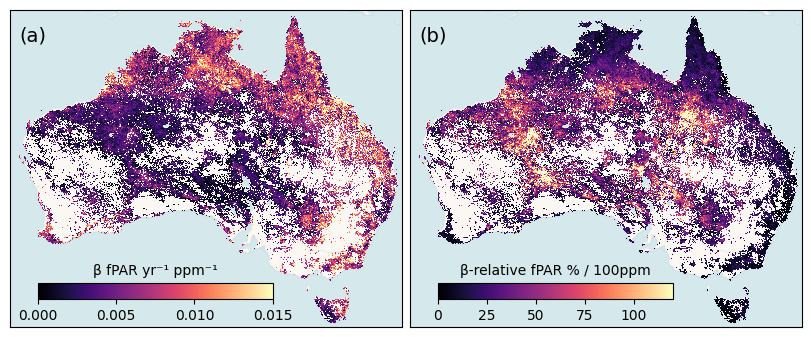

In [5]:
fig,ax=plt.subplots(1,2,figsize=(8,4),layout='constrained', sharey=True, sharex=True)

# 
if 'NDVI' in data_product:
    vmin=0
    vmax=0.015
else:
    vmin=0
    vmax=5
im = p_beta['beta'].plot(ax=ax[0], add_labels=False, vmin=vmin, vmax=vmax, cmap='magma', add_colorbar=False)
ax[0].axes.get_xaxis().set_ticks([])
ax[0].axes.get_yaxis().set_ticks([])
ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
# ax[0].set_title(f'\u03B2, {data_product}')
axins1 = inset_axes(ax[0], width="60%",height="5%",loc="lower left", borderpad=2)
cbar = fig.colorbar(im, cax=axins1,orientation='horizontal')
cbar.ax.set_title(f'\u03B2 {units}', fontsize=10)

im = p_beta['beta_relative'].plot(ax=ax[1], add_labels=False, vmin=0, vmax=120, cmap='magma', add_colorbar=False)
ax[1].axes.get_xaxis().set_ticks([])
ax[1].axes.get_yaxis().set_ticks([])
ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
# ax[1].set_title(f'\u03B2-relative, {data_product}')
axins1 = inset_axes(ax[1], width="60%",height="5%",loc="lower left", borderpad=2)
cbar = fig.colorbar(im, cax=axins1,orientation='horizontal')
cbar.ax.set_title(f'\u03B2-relative {units_relative}', fontsize=10);

if 'NDVI' in data_product:
    letters = ['(a)','(b)']
else:
    letters = ['(c)','(d)']

for a, l in zip(ax.ravel(), letters):
    a.text(0.025, 0.90, l ,  transform=a.transAxes, fontsize=14)

fig.savefig(f'{base}results/figs/Beta_{data_product}.png',
            bbox_inches='tight', dpi=300)

### Disaggregated by simple veg groups and bioclimatic zone

Create box plots so we can compare across datasets, environments etc.

### Land cover

In [6]:
lc = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_phenology/data/ESA_WorldCover_processed.nc').drop_vars('band')
lc_names = {
    1:'Trees',
    2:'Shrubs',
    3:'Grasses',
    4:'Sparse',
    5:'Crops'
}

def extract_vars(trends, var, classes_to_extract, lc, nvis_dict):
    dfs = []
    for c in classes_to_extract: #loop through veg classes
        veg_trends = trends.where(lc==c)
        df = veg_trends[[var]].drop_vars('spatial_ref').to_dataframe().rename({var:nvis_dict[c]},axis=1)
        dfs.append(df)
    
    #now append values for entire continent 
    dfs.append(trends[[var]].drop_vars('spatial_ref').to_dataframe().rename({var:'All'},axis=1))

    return pd.concat(dfs).dropna(axis=0, how='all')

simple_classes_to_plot = [1,2,3]

beta_lc = extract_vars(p_beta, 'beta', simple_classes_to_plot, lc, lc_names)
beta_relative_lc = extract_vars(p_beta, 'beta_relative', simple_classes_to_plot, lc, lc_names)

# add mean aridity to column name
trees_ai = round(mi.where(lc==1).mean().item(), 2)
shrub_ai = round(mi.where(lc==2).mean().item(), 2)
grass_ai = round(mi.where(lc==3).mean().item(), 2)
all_ai = round(mi.where(~np.isnan(p_beta['beta'])).mean().item(), 2)
ai_lc = [trees_ai, shrub_ai, grass_ai, all_ai]

## add number of non-nan samples to column name
beta_lc.columns =  [f'{col}\nMI={a}' for col, a in zip(beta_lc.columns, ai_lc)]
beta_relative_lc.columns =  beta_lc.columns

In [7]:
stats_lc = beta_lc.describe()
stats_lc_relative = beta_relative_lc.describe()

for c in beta_lc.columns:
    # median = stats_lc[c].loc['50%']
    # iqr = stats_lc[c].loc['75%']  - stats_lc[c].loc['25%']
    # print(f'{c[0:3]}: {median.item():.2f}, IQR {iqr.item():.2f} {units}')
    mean = stats_lc[c].loc['mean']
    std = stats_lc[c].loc['std']
    print(f'{c[0:3]}: {mean.item():.2f} \u00B1 {std.item():.2f} {units}')

    mean = stats_lc_relative[c].loc['mean']
    std = stats_lc_relative[c].loc['std']
    print(f'{c[0:3]}: {mean.item():.2f} \u00B1 {std.item():.2f} {units_relative}')
    print('----------------------------------')

Tre: 0.01 ± 0.00 fPAR yr⁻¹ ppm⁻¹
Tre: 20.29 ± 15.25 fPAR % / 100ppm
----------------------------------
Shr: 0.00 ± 0.00 fPAR yr⁻¹ ppm⁻¹
Shr: 40.61 ± 32.69 fPAR % / 100ppm
----------------------------------
Gra: 0.00 ± 0.00 fPAR yr⁻¹ ppm⁻¹
Gra: 43.79 ± 32.41 fPAR % / 100ppm
----------------------------------
All: 0.01 ± 0.00 fPAR yr⁻¹ ppm⁻¹
All: 37.25 ± 30.84 fPAR % / 100ppm
----------------------------------


In [8]:
import matplotlib.patheffects as path_effects

def add_median_labels(ax: plt.Axes, fmt: str = ".1f") -> None:
    """Add text labels to the median lines of a seaborn boxplot.

    Args:
        ax: plt.Axes, e.g. the return value of sns.boxplot()
        fmt: format string for the median value
    """
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if "Patch" in str(c)]
    start = 5 #depending on the start position we grab median or mean!
              # 4==median, 5==mean  
    if not boxes: 
        boxes = [c for c in ax.get_lines() if len(c.get_xdata()) == 5]
        start += 1
    lines_per_box = len(lines) // len(boxes)
    for median in lines[start::lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if len(set(median.get_xdata())) == 1 else y
        text = ax.text(x, y, f'{value:{fmt}}', ha='center', va='center',
                       color='white') #fontweight='bold'
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])

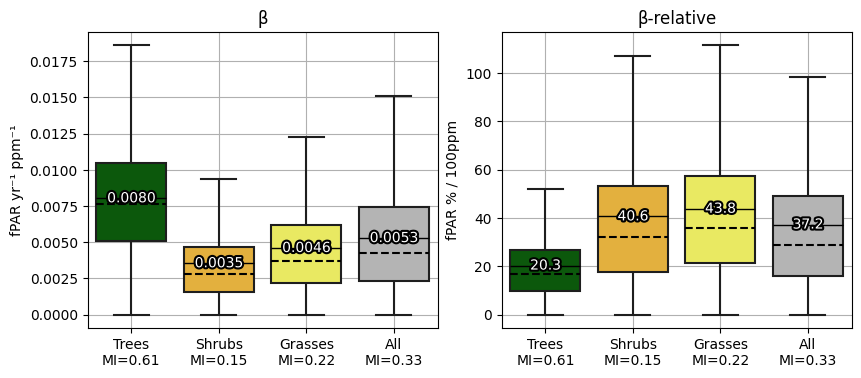

In [9]:
dd = [beta_lc, beta_relative_lc]
names=['beta', 'beta_relative']

categories =['tree', 'shrub', 'grass', 'all'] # 'sparse', 
colours = ['#006400', '#ffbb22', '#ffff4c', '#b4b4b4'] # '#b4b4b4',
cmap = LinearSegmentedColormap.from_list("landcover_cmap", colours, N=len(colours))

flierprops = dict(markerfacecolor='0.75', markersize=3, linestyle='none')
fig,axes=plt.subplots(1,2, figsize=(8.5,3.75), layout='constrained')

for d,n,ax in zip(dd,names,axes.ravel()):
    if "relative" not in n:
        title=f'\u03B2' #{data_product}
        label=units
        if 'NDVI' in data_product:
            fmt = ".4f"
        else:
            fmt=".2f"
    else:
        title=f'\u03B2-relative'
        label=units_relative
        fmt = ".1f"

    # d.columns = [f'{col}\nN={count}' for col, count in zip(d.columns, d.count().values)]
    bp = sb.boxplot(d, ax=ax, palette=colours, linewidth=1.5, showfliers=False,meanline=True,
                    showmeans=True, medianprops={'color':'k', 'linestyle':'--'}, meanprops={'color':'k', 'linestyle':'-'}) # 
    ax.set_title(title)
    ax.set_ylabel(label, fontsize=10)
    ax.grid()
    add_median_labels(ax, fmt=fmt)
    
fig.supxlabel(None) 

fig.savefig(f'{base}results/figs/beta_landcover_boxplots_{data_product}.png',
            bbox_inches='tight', dpi=300) 

## By climate zones

In [10]:
clim = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/koppen_major_climate_zones.nc')
clim = clim-50
clim_names = {
    0:'Desert',
    1:'Semiarid',
    3:'Subtropical',
    2:'Temperate',
    4:'Tropical',
    5:'Equatorial'
}

clim_classes_to_plot = [0,1,3,4,2,5] #reordered so AI increases
beta_clim = extract_vars(p_beta, 'beta', clim_classes_to_plot, clim, clim_names)
beta_relative_clim = extract_vars(p_beta, 'beta_relative', clim_classes_to_plot, clim, clim_names)

# add mean aridity to column name
desert_ai = round(mi.where(clim==0).mean().item(), 2)
semiarid_ai = round(mi.where(clim==1).mean().item(), 2)
temperate_ai = round(mi.where(clim==2).mean().item(), 2)
subtropical_ai = round(mi.where(clim==3).mean().item(), 2)
tropical_ai = round(mi.where(clim==4).mean().item(), 2)
equatorial_ai = round(mi.where(clim==5).mean().item(), 2)

ai_clim = [desert_ai, semiarid_ai, subtropical_ai, tropical_ai, temperate_ai, equatorial_ai]

#remove 'all' column
beta_clim = beta_clim.loc[:,~beta_clim.columns.str.startswith('All')]
beta_relative_clim = beta_relative_clim.loc[:,~beta_relative_clim.columns.str.startswith('All')]

## add number of non-nan samples to column name, also add mean Aridity index
beta_clim.columns =  [f'{col}\nMI={a}' for col, a in zip(beta_clim.columns, ai_clim)]
beta_relative_clim.columns =  beta_clim.columns


### Print summary stats

In [11]:
stats_clim = beta_clim.describe()
stats_clim_relative = beta_relative_clim.describe()

for c in beta_clim.columns:
    mean = stats_clim[c].loc['mean']
    std = stats_clim[c].loc['std']
    print(f'{c[0:5]}: {mean.item():.2f} \u00B1 {std.item():.2f} {units}')

    mean = stats_clim_relative[c].loc['mean']
    std = stats_clim_relative[c].loc['std']
    print(f'{c[0:5]}: {mean.item():.2f} \u00B1 {std.item():.2f} {units_relative}')
    print('----------------------------------')

Deser: 0.00 ± 0.00 fPAR yr⁻¹ ppm⁻¹
Deser: 48.66 ± 36.05 fPAR % / 100ppm
----------------------------------
Semia: 0.01 ± 0.00 fPAR yr⁻¹ ppm⁻¹
Semia: 39.60 ± 27.13 fPAR % / 100ppm
----------------------------------
Subtr: 0.01 ± 0.00 fPAR yr⁻¹ ppm⁻¹
Subtr: 21.30 ± 12.46 fPAR % / 100ppm
----------------------------------
Tropi: 0.01 ± 0.00 fPAR yr⁻¹ ppm⁻¹
Tropi: 19.88 ± 11.90 fPAR % / 100ppm
----------------------------------
Tempe: 0.01 ± 0.00 fPAR yr⁻¹ ppm⁻¹
Tempe: 11.98 ± 8.92 fPAR % / 100ppm
----------------------------------
Equat: 0.01 ± 0.00 fPAR yr⁻¹ ppm⁻¹
Equat: 12.26 ± 6.63 fPAR % / 100ppm
----------------------------------


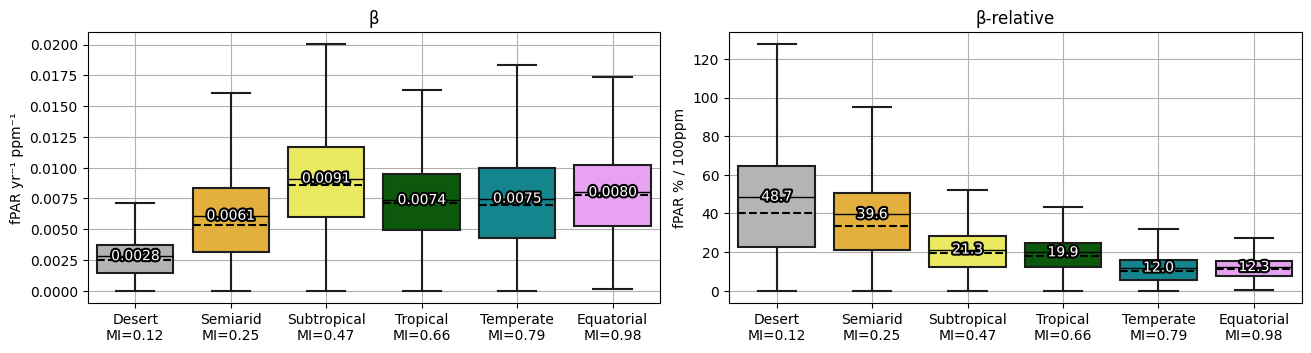

In [12]:
dd = [beta_clim, beta_relative_clim]
names=['beta', 'beta_relative']

categories =['Desert', 'Grassland', 'Subtropical','Tropical', 'Temperate', 'Equatorial']
colours = ['#b4b4b4',  '#ffbb22', '#ffff4c','#006400', '#0096a0', '#f096ff']
cmap = LinearSegmentedColormap.from_list("landcover_cmap", colours, N=len(colours))

flierprops = dict(markerfacecolor='0.75', markersize=3, linestyle='none')
fig,axes=plt.subplots(1,2, figsize=(13,3.5), layout='constrained')# sharey='row' # 

for d,n,ax in zip(dd,names,axes.ravel()):
    
    if "relative" not in n:
        title=f'\u03B2'
        label=units
        if 'NDVI' in data_product:
            fmt = ".4f"
        else:
            fmt=".2f"
    else:
        title=f'\u03B2-relative'
        label=units_relative
        fmt = ".1f"

    # d.columns = [f'{col}\nN={count}' for col, count in zip(d.columns, d.count().values)]
    sb.boxplot(d, ax=ax, palette=colours, linewidth=1.5, showfliers=False,meanline=True,
        showmeans=True, medianprops={'color':'k', 'linestyle':'--'}, meanprops={'color':'k', 'linestyle':'-'})
    ax.set_title(title)
    ax.set_ylabel(label, fontsize=10)
    ax.grid()
    add_median_labels(ax, fmt=fmt)
fig.supxlabel(None) 
fig.savefig(f'{base}results/figs/beta_climate_boxplots_{data_product}.png',
            bbox_inches='tight', dpi=300) 

## By climate-landcover zone

In [13]:
koppen = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/koppen_and_landcover.nc').drop_vars('band')
kopp_cat =['Desert\n', 'Semiarid\n', 'Temperate\n', 'Subtropical\n', 'Tropical\n', 'Equatorial\n']

categories=[]
for k in kopp_cat:
    categories.append(k+'Tree')
for k in kopp_cat:
    categories.append(k+'Shrub')
for k in kopp_cat:
    categories.append(k+'Grass')

categories.remove('Equatorial\nShrub')
categories.remove('Subtropical\nShrub')
categories.remove('Tropical\nShrub')
categories.remove('Temperate\nShrub')
categories.remove('Equatorial\nGrass')
categories.remove('Desert\nTree')

koppen_names = {i:c for i,c in zip(np.unique(koppen)[0:-1],categories)}
koppen_classes_to_plot = list(koppen_names.keys())

In [14]:
beta_koppen = extract_vars(p_beta, 'beta', koppen_classes_to_plot, koppen, koppen_names)
beta_relative_koppen = extract_vars(p_beta, 'beta_relative', koppen_classes_to_plot, koppen, koppen_names)

## add number of non-nan samples to column name
beta_koppen.columns =  [f'{col}\nN={count}' for col, count in zip(beta_koppen.columns, beta_koppen.count().values)]
beta_relative_koppen.columns =  beta_koppen.columns#

#remove 'all' column
beta_koppen = beta_koppen.loc[:,~beta_koppen.columns.str.startswith('All')]
beta_relative_koppen = beta_relative_koppen.loc[:,~beta_relative_koppen.columns.str.startswith('All')]

### Print summary stats

In [15]:
stats_koppen = beta_koppen.describe()
stats_koppen_relative = beta_relative_koppen.describe()

for c in stats_koppen.columns:
    mean = stats_koppen[c].loc['mean']
    std = stats_koppen[c].loc['std']
    print(f'{c}: {mean.item():.2f} \u00B1 {std.item():.2f} {units}')

    mean = stats_koppen_relative[c].loc['mean']
    std = stats_koppen_relative[c].loc['std']
    print(f'        {mean.item():.2f} \u00B1 {std.item():.2f} {units_relative}')
    print('----------------------------------')

Semiarid
Tree
N=11696: 0.01 ± 0.00 fPAR yr⁻¹ ppm⁻¹
        31.62 ± 19.57 fPAR % / 100ppm
----------------------------------
Temperate
Tree
N=10488: 0.01 ± 0.00 fPAR yr⁻¹ ppm⁻¹
        10.86 ± 8.12 fPAR % / 100ppm
----------------------------------
Subtropical
Tree
N=6966: 0.01 ± 0.00 fPAR yr⁻¹ ppm⁻¹
        19.59 ± 12.34 fPAR % / 100ppm
----------------------------------
Tropical
Tree
N=12665: 0.01 ± 0.00 fPAR yr⁻¹ ppm⁻¹
        18.81 ± 9.69 fPAR % / 100ppm
----------------------------------
Equatorial
Tree
N=1288: 0.01 ± 0.00 fPAR yr⁻¹ ppm⁻¹
        12.44 ± 6.49 fPAR % / 100ppm
----------------------------------
Desert
Shrub
N=15838: 0.00 ± 0.00 fPAR yr⁻¹ ppm⁻¹
        43.00 ± 34.35 fPAR % / 100ppm
----------------------------------
Semiarid
Shrub
N=6968: 0.00 ± 0.00 fPAR yr⁻¹ ppm⁻¹
        37.12 ± 29.41 fPAR % / 100ppm
----------------------------------
Desert
Grass
N=44895: 0.00 ± 0.00 fPAR yr⁻¹ ppm⁻¹
        51.14 ± 36.35 fPAR % / 100ppm
----------------------------------
Semiarid


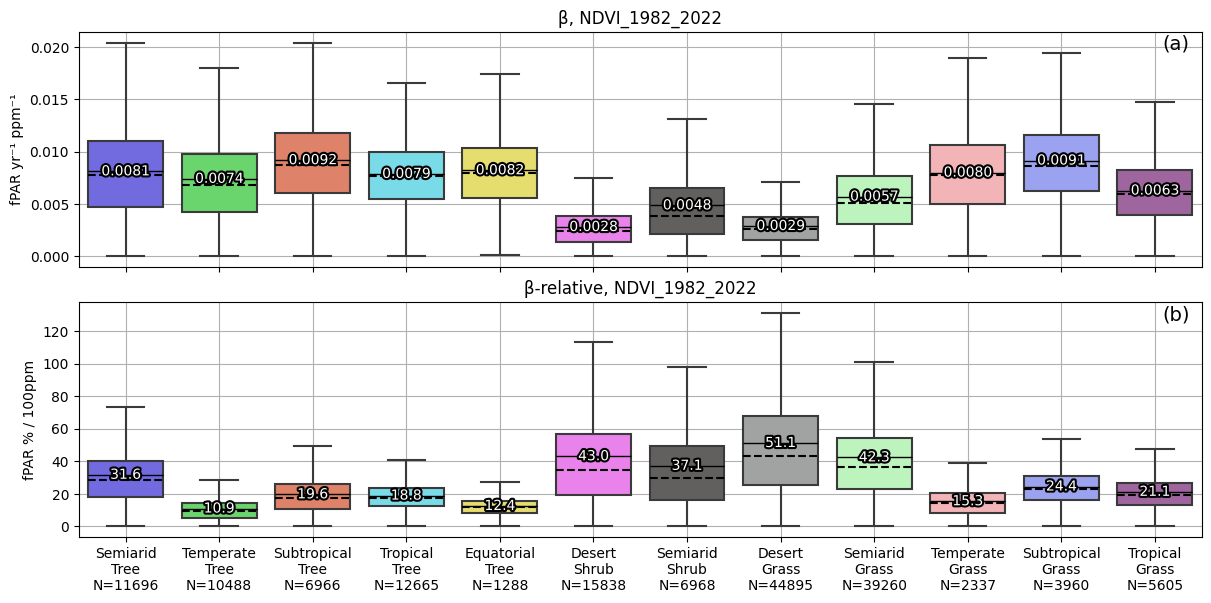

In [16]:
dd = [beta_koppen, beta_relative_koppen]
names=['beta', 'beta_relative']

colours = distinctipy.get_colors(len(categories), pastel_factor=0.5, rng=2)
cmap = LinearSegmentedColormap.from_list("cwc", colours, N=len(categories))

flierprops = dict(markerfacecolor='0.75', markersize=3, linestyle='none')
fig,axes=plt.subplots(2,1, figsize=(12,6), layout='constrained', sharex=True)# sharey='row' # 

for d,n,ax in zip(dd,names,axes.ravel()):
    
    if "relative" not in n:
        title=f'\u03B2, {data_product}'
        label=units
        if 'NDVI' in data_product:
            fmt = ".4f"
        else:
            fmt=".2f"
    else:
        title=f'\u03B2-relative, {data_product}'
        label=units_relative
        fmt = ".1f"

    sb.boxplot(d, ax=ax, palette=colours, linewidth=1.5, showfliers=False,meanline=True,
        showmeans=True, medianprops={'color':'k', 'linestyle':'--'}, meanprops={'color':'k', 'linestyle':'-'})
    ax.set_title(title)
    ax.set_ylabel(label, fontsize=10)
    ax.grid()
    add_median_labels(ax, fmt=fmt)

axes[0].text(0.965, 0.925, f'(a)',  transform=axes[0].transAxes, fontsize=14)
axes[1].text(0.965, 0.925, f'(b)',  transform=axes[1].transAxes, fontsize=14)

fig.supxlabel(None) 
fig.savefig(f'{base}results/figs/beta_koppen_boxplots_{data_product}.png',
            bbox_inches='tight', dpi=300) 

## Megaplot for thesis


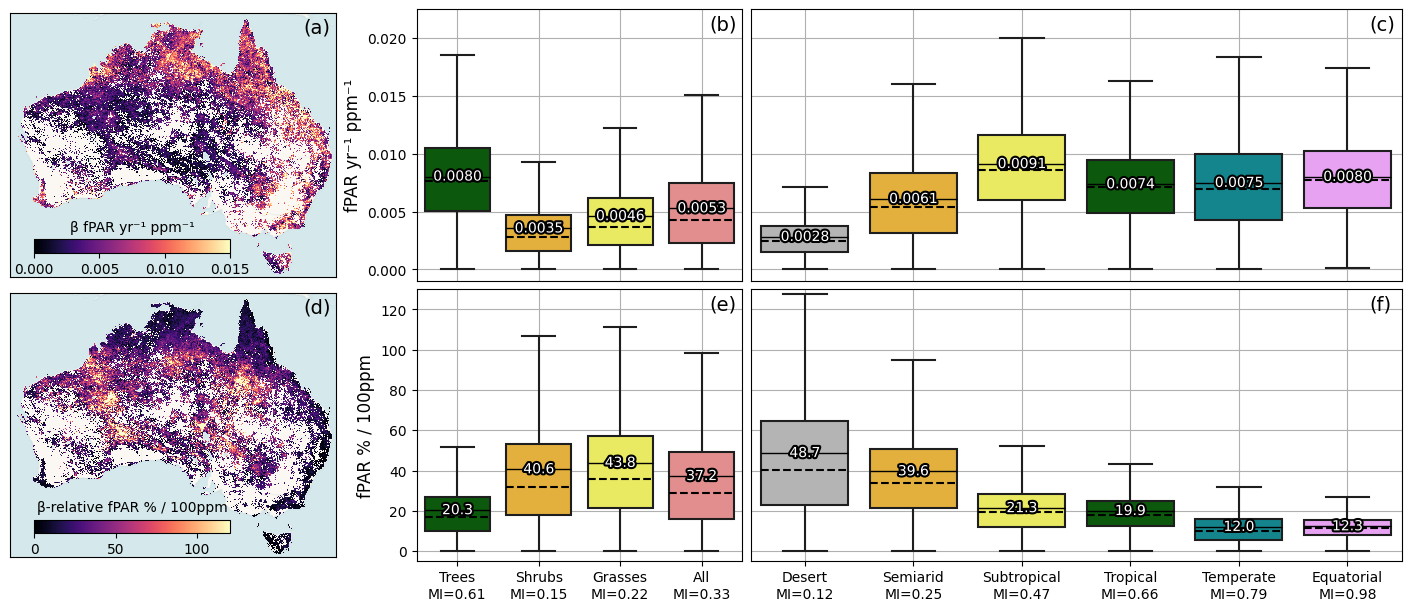

In [17]:
layout = [
    ['A', 'B', 'C', 'C'],
    ['D', 'E', 'F', 'F']
]

# Create the mosaic plot
fig, ax = plt.subplot_mosaic(layout, figsize=(14, 6),  layout='constrained')

im = p_beta['beta'].plot(ax=ax['A'], add_labels=False, vmin=vmin, vmax=vmax, cmap='magma', add_colorbar=False)
ax['A'].axes.get_xaxis().set_ticks([])
ax['A'].axes.get_yaxis().set_ticks([])
ctx.add_basemap(ax['A'], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
# ax[0].set_title(f'\u03B2, {data_product}')
axins1 = inset_axes(ax['A'], width="60%",height="5%",loc="lower left", borderpad=1.75)
cbar = fig.colorbar(im, cax=axins1,orientation='horizontal')
cbar.ax.set_title(f'\u03B2 {units}', fontsize=10)

im = p_beta['beta_relative'].plot(ax=ax['D'], add_labels=False, vmin=0, vmax=120, cmap='magma', add_colorbar=False)
ax['D'].axes.get_xaxis().set_ticks([])
ax['D'].axes.get_yaxis().set_ticks([])
ctx.add_basemap(ax['D'], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
# ax[1].set_title(f'\u03B2-relative, {data_product}')
axins1 = inset_axes(ax['D'], width="60%",height="5%",loc="lower left", borderpad=1.75)
cbar = fig.colorbar(im, cax=axins1,orientation='horizontal')
cbar.ax.set_title(f'\u03B2-relative {units_relative}', fontsize=10);

#---------------------------------------------------------------------------------
categories =['tree', 'shrub', 'grass', 'all'] # 'sparse', 
colours = ['#006400', '#ffbb22', '#ffff4c', 'lightcoral'] # '#b4b4b4',
cmap = LinearSegmentedColormap.from_list("landcover_cmap", colours, N=len(colours))
flierprops = dict(markerfacecolor='0.75', markersize=3, linestyle='none')

if 'NDVI' in data_product:
    fmt = ".4f"
    ylim_abs=-0.001,0.0225
    ylim_relative=-5,130
else:
    fmt=".2f"
    ylim_abs=-0.5,7
    ylim_relative=-5,100

sb.boxplot(beta_lc, ax=ax['B'], palette=colours, linewidth=1.5, showfliers=False, meanline=True,
    showmeans=True, medianprops={'color':'k', 'linestyle':'--'}, meanprops={'color':'k', 'linestyle':'-'})
ax['B'].set_title(None)
ax['B'].set_ylabel(units, fontsize=12)
ax['B'].set_ylim(ylim_abs)
add_median_labels(ax['B'], fmt=fmt)
ax['B'].set_xticklabels([])
ax['B'].tick_params(axis='x', length=0) 
ax['B'].grid()

sb.boxplot(beta_relative_lc, ax=ax['E'], palette=colours, linewidth=1.5, showfliers=False, meanline=True,
        showmeans=True, medianprops={'color':'k', 'linestyle':'--'}, meanprops={'color':'k', 'linestyle':'-'})
ax['E'].set_title(None)
ax['E'].set_ylim(ylim_relative)
ax['E'].set_ylabel(units_relative, fontsize=12)
ax['E'].grid()
add_median_labels(ax['E'], fmt=".1f")
# fig.supxlabel(None) 
#----------------------------------------------------------------------------------

categories =['Desert', 'Grassland', 'Subtropical','Tropical', 'Temperate', 'Equatorial']
colours = ['#b4b4b4',  '#ffbb22', '#ffff4c','#006400', '#0096a0', '#f096ff']
cmap = LinearSegmentedColormap.from_list("landcover_cmap", colours, N=len(colours))
sb.boxplot(beta_clim, ax=ax['C'], palette=colours, linewidth=1.5, showfliers=False,meanline=True,
        showmeans=True, medianprops={'color':'k', 'linestyle':'--'}, meanprops={'color':'k', 'linestyle':'-'})
ax['C'].set_title(None)
ax['C'].set_ylabel(None)
ax['C'].set_xticklabels([])
ax['C'].tick_params(axis='x', length=0) 
ax['C'].set_yticklabels([])
ax['C'].tick_params(axis='y', length=0) 
ax['C'].set_ylim(ylim_abs)
add_median_labels(ax['C'], fmt=fmt)
ax['C'].grid()

sb.boxplot(beta_relative_clim, ax=ax['F'], palette=colours, linewidth=1.5, showfliers=False,meanline=True,
        showmeans=True, medianprops={'color':'k', 'linestyle':'--'}, meanprops={'color':'k', 'linestyle':'-'})
ax['F'].set_title(None)
ax['F'].set_ylim(ylim_relative)
ax['F'].set_ylabel(None)
ax['F'].set_yticklabels([])
ax['F'].tick_params(axis='y', length=0) 
ax['F'].grid()
add_median_labels(ax['F'], fmt=".1f")

#-----------------------------------------------------------------------------
if 'NDVI' in data_product:
    ax['A'].text(0.90, 0.925, f'(a)',  transform=ax['A'].transAxes, fontsize=14)
    ax['B'].text(0.90, 0.925, f'(b)',  transform=ax['B'].transAxes, fontsize=14)
    ax['C'].text(0.95, 0.925, f'(c)',  transform=ax['C'].transAxes, fontsize=14)
    ax['D'].text(0.90, 0.925, f'(d)',  transform=ax['D'].transAxes, fontsize=14)
    ax['E'].text(0.90, 0.925, f'(e)',  transform=ax['E'].transAxes, fontsize=14)
    ax['F'].text(0.95, 0.925, f'(f)',  transform=ax['F'].transAxes, fontsize=14);
else:
    ax['A'].text(0.90, 0.925, f'(g)',  transform=ax['A'].transAxes, fontsize=14)
    ax['B'].text(0.90, 0.925, f'(h)',  transform=ax['B'].transAxes, fontsize=14)
    ax['C'].text(0.95, 0.925, f'(i)',  transform=ax['C'].transAxes, fontsize=14)
    ax['D'].text(0.90, 0.925, f'(j)',  transform=ax['D'].transAxes, fontsize=14)
    ax['E'].text(0.90, 0.925, f'(k)',  transform=ax['E'].transAxes, fontsize=14)
    ax['F'].text(0.95, 0.925, f'(l)',  transform=ax['F'].transAxes, fontsize=14);

fig.savefig(f'{base}results/figs/beta_megaplot_{data_product}.png',
            bbox_inches='tight', dpi=300) 

## Across environmental gradients

In [18]:
beta_df = p_beta.to_dataframe().drop(['spatial_ref'],axis=1)
beta_df['P:PET'] = mi.where(~np.isnan(p_beta['beta'])).to_dataframe().drop(['spatial_ref'],axis=1)
beta_df['Woody Cover Fraction'] = trees.where(~np.isnan(p_beta['beta'])).to_dataframe().drop(['spatial_ref'],axis=1)
# beta_df['VegH (m)'] = vegh.where(~np.isnan(p_beta['beta'])).to_dataframe().drop(['spatial_ref'],axis=1)
beta_df['Length of Season (days)'] = p_average['LOS'].where(~np.isnan(p_beta['beta'])).to_dataframe().drop(['spatial_ref'],axis=1)

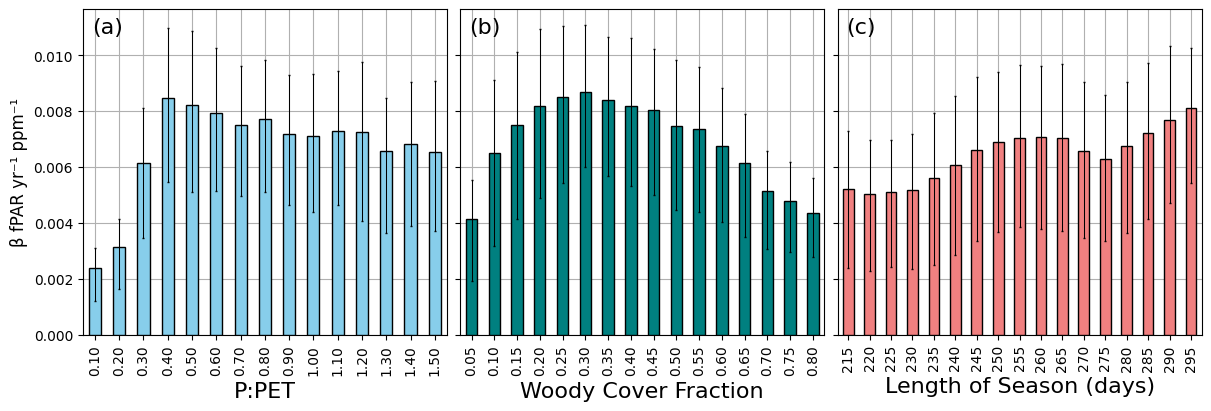

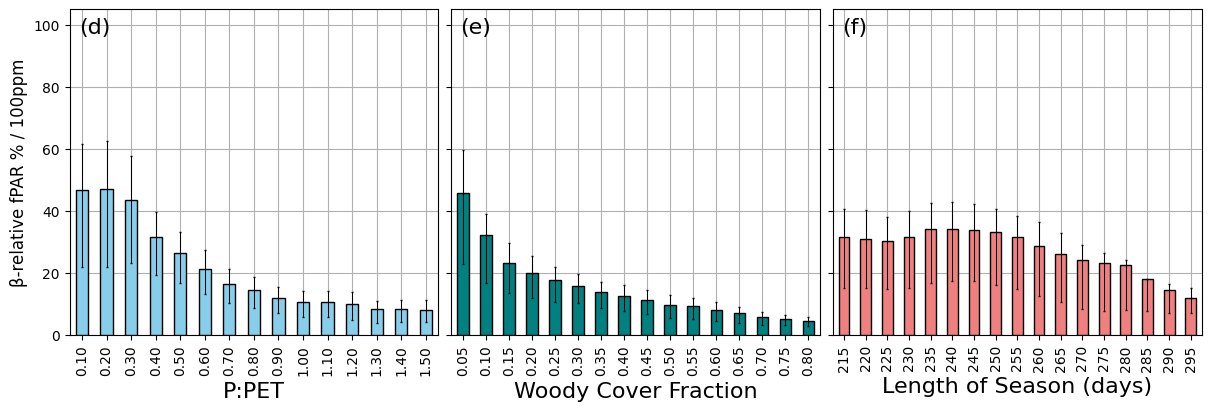

In [19]:
env_vars = ['P:PET', 'Woody Cover Fraction', 'Length of Season (days)'] #'VegH (m)'
cls = ['skyblue', 'teal', 'lightcoral'] #'violet',

bins_master = [
    np.arange(0,1.6,0.1),
    np.arange(0,0.85, 0.05),
    # np.arange(0,24,1),
    np.arange(210,300,5)
    # np.arange(0.05,0.35,0.025),
    # np.arange(0,0.45,0.05)
    ]

y_vars = ['beta', 'beta_relative'] #'beta_relative'

for y_var in y_vars:
    fig,axes=plt.subplots(1,3, figsize=(12,4),  layout='constrained', sharey=True)
    
    for ev,b,c,ax,i in zip(env_vars, bins_master, cls, axes.ravel(), range(0, len(env_vars))): 
        bins = pd.cut(beta_df[ev], bins=b, right=False)
        grouped = beta_df.groupby(bins, observed=True)[y_var].mean()
        yerr_up = beta_df.groupby(bins, observed=True)[y_var].quantile(0.75) - grouped
        yerr_low = grouped - beta_df.groupby(bins, observed=True)[y_var].quantile(0.25)
        # yerror = beta_df.groupby(bins, observed=True)[y_var].std()
        grouped.plot(kind='bar', color=c, edgecolor='black', ax=ax,
                     zorder=10, yerr=(yerr_low, yerr_up), rot=90, error_kw=dict(ecolor='k', elinewidth=0.75, capsize=1)) #
        if i <=1:
            ax.set_xticklabels(['{:3.2f}'.format(x) for x in b[1:].astype('float16')])
        else:
            ax.set_xticklabels(b[1:].astype('int16'))

        ax.set_xlabel(ev, fontsize=16)
        ax.grid()
        if y_var=='beta_relative':
            if 'NDVI' in data_product:
                ax.set_ylim(0,105)
            else:
                ax.set_ylim(0,55)
    
    if y_var=='beta':
        axes[0].set_ylabel('\u03B2 '+ units, fontsize=12)
    else:
        axes[0].set_ylabel('\u03B2-relative ' +units_relative, fontsize=12)
    
    if y_var=='beta':
    # if 'NDVI' in data_product:
        letters = ['(a)','(b)','(c)']
    else:
        letters = ['(d)', '(e)','(f)']#['(d)', '(e)','(f)', '(g)']

    for a, l in zip(axes.ravel(), letters):
        a.text(0.025, 0.925, l ,  transform=a.transAxes, fontsize=16)
    
    fig.savefig(f'{base}results/figs/{y_var}_binned_{data_product}.png',
                        bbox_inches='tight', dpi=300)


In [20]:
# sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
# from _prediction import allNaN_arg

In [21]:
# p_attribution_ml = assign_crs(xr.open_dataset(f'{base}results/combined_tiles/{data_product}/attribution_resource_limitation_{data_product}.nc'), crs='EPSG:4326')

# clim_most_important_var_ml = allNaN_arg(np.abs(p_attribution_ml.PLS_coefficent), dim='feature',stat='max', idx=False)

# rank_srad_ml = p_attribution_ml['PLS_coefficent'].rank('feature').sel(feature='srad')
# rank_rain_ml = p_attribution_ml['PLS_coefficent'].rank('feature').sel(feature='rain')

# resource_limited = xr.where(clim_most_important_var_ml==0, 0, clim_most_important_var_ml)
# resource_limited = xr.where((resource_limited==1) | (resource_limited==4), 2, resource_limited)
# resource_limited = xr.where((resource_limited>=0) & (resource_limited<3), resource_limited, np.nan)

# beta_resources = extract_vars(p_beta, 'beta', [1,2], resource_limited, {1:'Light-limited', 2:'Water-limited'})
# beta_relative_resources = extract_vars(p_beta, 'beta_relative',  [1,2], resource_limited, {1:'Light-limited', 2:'Water-limited'})

# ## add number of non-nan samples to column name
# beta_resources.columns =  [f'{col}\nN={count}' for col, count in zip(beta_resources.columns, beta_resources.count().values)]
# beta_relative_resources.columns =  [f'{col}\nN={count}' for col, count in zip(beta_relative_resources.columns, beta_relative_resources.count().values)]

# #remove 'all' column
# beta_resources = beta_resources.loc[:,~beta_resources.columns.str.startswith('All')]
# beta_relative_resources = beta_relative_resources.loc[:,~beta_relative_resources.columns.str.startswith('All')]

In [22]:
# dd = [beta_resources, beta_relative_resources]
# names=['beta', 'beta_relative']

# categories =['Light-limited', 'Water-limited']
# colours = distinctipy.get_colors(len(categories), pastel_factor=0.5, rng=2)
# # cmap = LinearSegmentedColormap.from_list("landcover_cmap", colours, N=len(colours))

# flierprops = dict(markerfacecolor='0.75', markersize=3, linestyle='none')
# fig,axes=plt.subplots(1,2, figsize=(7,3.5), layout='constrained')# sharey='row' # 

# for d,n,ax in zip(dd,names,axes.ravel()):
    
#     if "relative" not in n:
#         title=f'\u03B2, {data_product}'
#         label=units
#         if 'NDVI' in data_product:
#             fmt = ".4f"
#         else:
#             fmt=".2f"
#     else:
#         title=f'\u03B2-relative, {data_product}'
#         label=units_relative
#         fmt = ".1f"

#     # d.columns = [f'{col}\nN={count}' for col, count in zip(d.columns, d.count().values)]
#     sb.boxplot(d, ax=ax, palette=colours, linewidth=1.5, showfliers=False) #
#     ax.set_title(title)
#     ax.set_ylabel(label, fontsize=10)
#     ax.grid()
#     add_median_labels(ax, fmt=fmt)
# fig.supxlabel(None);

# fig.savefig(f'{base}results/figs/beta_resource_limited_boxplots_{data_product}.png',
#             bbox_inches='tight', dpi=300) 